# Data Visualization and Modeling
After analyzing the data and cleaning/transforming it, I wanted to see what can be done with the final analysis.

I explore a couple of different avenues in this notebook, namely:
- Analysis of Relationships
- Analysis of Vehicles for Investment 
- Identification of the highest-value 'missed opportunities' in the fundraising campaign.

In [0]:
#Creating joined DF
joined_df = spark.table("default.prod_accounts_commitments_joined")

### VehicleType Analysis

 I'm going to plot out the Number of Commitments vs Average Commitment for each VehicleType on a scatterplot to get a deeper understanding of the main strategies for each fund. We are also going to represent the size of each fund through bubble sizes.

In [0]:
from pyspark.sql.functions import count, avg, sum as _sum

vehicle_summary_df = joined_df.groupBy("VehicleType").agg(
    count("Commitment").alias("num_commitments"),
    avg("Commitment").alias("avg_commitment"),
    _sum("Commitment").alias("total_commitment")
).orderBy("num_commitments", ascending=False)


In [0]:
vehicle_summary_pd = vehicle_summary_df.toPandas()


In [0]:
import plotly.graph_objects as go
import numpy as np

df = vehicle_summary_pd.copy()

# Bubble sizing: Plotly uses area-based sizing. 
# sizeref = 2 * max(size) / (size_max^2)
size_max = 60  # max bubble diameter in px (tweak to taste)
sizes = df["total_commitment"].to_numpy()
sizeref = 2.0 * sizes.max() / (size_max ** 2)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df["num_commitments"],
    y=df["avg_commitment"],
    mode="markers+text",
    text=df["VehicleType"],                 # labels on points
    textposition="top center",
    marker=dict(
        size=sizes,                         # raw sizes; Plotly scales using sizeref
        sizemode="area",
        sizeref=sizeref,
        sizemin=4,
        color="mediumseagreen",
        opacity=0.6,
        line=dict(width=0.5, color="black")
    ),
    # Custom hover with nice formatting
    customdata=np.stack(
        [df["num_commitments"], df["avg_commitment"], df["total_commitment"], df["VehicleType"]],
        axis=-1
    ),
    hovertemplate=(
        "<b>%{customdata[3]}</b><br>"
        "Num commitments: %{customdata[0]:,}<br>"
        "Avg commitment: $%{customdata[1]:,.0f}<br>"
        "Total commitment: $%{customdata[2]:,.0f}<extra></extra>"
    )
))

fig.update_layout(
    title="Avg Commitment vs Number of Commitments by VehicleType (Bubble = Total Commitment)",
    xaxis_title="Number of Commitments",
    yaxis_title="Average Commitment ($)",
    template="plotly_white",
    width=900,
    height=550
)

fig.show()


As we can see, the Main Fund and SMA funds are extreme outliers and almost opposites in strategy. Where the Main Fund commits to a high number of smaller commitments, the SMA fund commits to a low number of high commitments. The rest of the funds tend to fall somewhere in between.

### RelationshipType Analysis
Next I want to to understand commitment versus Relationship Type. We can repeat the same process as above to get a deeper understanding of the data.

In [0]:
from pyspark.sql.functions import count, avg, sum
joined_df.groupBy("RelationshipType").agg(
    count("Commitment").alias("num_commitments"),
    avg("Commitment").alias("avg_commitment"),
    sum("Commitment").alias("total_commitment")
).orderBy("total_commitment", ascending=False).show(50)


+--------------------+---------------+--------------------+--------------------+
|    RelationshipType|num_commitments|      avg_commitment|    total_commitment|
+--------------------+---------------+--------------------+--------------------+
|     Limited Partner|           4270|   8410634.491606556|3.591340927915999...|
|Limited Partner, ...|            420|   9380452.138952384|3.9397898983600016E9|
|             unknown|           1674|  1462546.6571146958|2.4483031040100007E9|
|a16z Vehicle, Lim...|             75|      2.1331303584E7|      1.5998477688E9|
|Friends & Family,...|           1027|   799228.5959006825|  8.20807767990001E8|
|Limited Partner, ...|             28|2.8826236931428574E7|      8.0713463408E8|
|    a16z Employee LP|            418|   1456072.120741627|      6.0863814647E8|
|           Exited LP|              8|       2.425189394E7|      1.9401515152E8|
|Limited Partner, ...|              1|               5.0E7|               5.0E7|
|        a16z Vehicle|      

In [0]:
from pyspark.sql.functions import count, avg, sum as _sum

relationship_summary_df = joined_df.groupBy("RelationshipType").agg(
    count("Commitment").alias("num_commitments"),
    avg("Commitment").alias("avg_commitment"),
    _sum("Commitment").alias("total_commitment")
).orderBy("num_commitments", ascending=False)


In [0]:
relationship_summary_pd = relationship_summary_df.toPandas()


In [0]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

# --- START: sanitize and size helpers ---
def prep_bubble_df(df, x_col, y_col, size_col):
    df = df.copy()

    # Coerce to numeric and replace inf with NaN
    for c in [x_col, y_col, size_col]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.replace([np.inf, -np.inf], np.nan)

    # Drop rows missing x or y; keep size NaN as 0 (renders as tiny/hidden bubbles)
    df = df.dropna(subset=[x_col, y_col])
    df[size_col] = df[size_col].fillna(0.0).clip(lower=0)  # no negatives for bubble area

    return df

def compute_sizeref(sizes, size_max_px=60):
    max_size = float(np.max(sizes)) if len(sizes) else 0.0
    # Avoid division by zero; if all sizes are 0, use 1.0 as a safe baseline
    return (2.0 * (max_size if max_size > 0 else 1.0)) / (size_max_px ** 2)
# --- END helpers ---

# Example for your relationship_summary_pd
df = prep_bubble_df(relationship_summary_pd, "num_commitments", "avg_commitment", "total_commitment")

# Optional relabel for "Compliance"
df["label_for_plot"] = np.where(
    df["RelationshipType"].astype(str).str.contains("Compliance", na=False),
    "Do not Target, Political Contribution",
    df["RelationshipType"]
)

# Only annotate top 10 by total commitment
top10_idx = df.nlargest(10, "total_commitment").index
text_labels = df["label_for_plot"].where(df.index.isin(top10_idx), "")

sizes = df["total_commitment"].to_numpy()
sizeref = compute_sizeref(sizes, size_max_px=60)

fig = go.Figure(go.Scatter(
    x=df["num_commitments"],
    y=df["avg_commitment"],
    mode="markers+text",
    text=text_labels,                  # annotate only top 10
    textposition="top center",
    textfont=dict(size=9),
    marker=dict(
        size=sizes,                    # now free of NaN/inf
        sizemode="area",
        sizeref=sizeref,
        sizemin=4,
        color="darkorange",
        opacity=0.6,
        line=dict(width=0.5, color="black"),
    ),
    customdata=np.stack(
        [df["num_commitments"], df["avg_commitment"], df["total_commitment"], df["RelationshipType"]],
        axis=-1
    ),
    hovertemplate="<b>%{customdata[3]}</b><br>"
                  "Num commitments: %{customdata[0]:,}<br>"
                  "Avg commitment: $%{customdata[1]:,.0f}<br>"
                  "Total commitment: $%{customdata[2]:,.0f}<extra></extra>"
))

fig.update_layout(
    title="Avg Commitment vs Number of Commitments by RelationshipType (Bubble = Total Commitment)",
    xaxis_title="Number of Commitments",
    yaxis_title="Average Commitment ($)",
    template="plotly_white",
    width=900,
    height=550
)

fig.show()


Repeating the same process we saw above, we can see a similar spread where Limited Partners have the highest # of commitments but a lower average. Interestingly, Limited Partners who are mentioned as "Do Not Target" due to compliance have by far the highest average commitment. We can also see that relationships based on a16 Vehicle have significantly higher commitments compared to the mean, and Friends/Family relationships surprisingly have slightly lower contributions.

### Identifying Missed Opportunities
Lastly, I want to compare actual commitments against the BiteHighs for LPs to find LPs that could have committed much more than they actually did - in other words, the highest "missed opportunities" for fundraising.

In [0]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col

# --- Params ---
THRESHOLD_PCT = 50.0  

# --- Build missed_df (starting from joined_df) ---
filtered_df = (
    joined_df.select(
        "LimitedPartner", "FundName",
        "AccountType", "RelationshipType", "VehicleType",
        "Organization_name_hashed", "AccountLead", "HQCityStateCountry",
        "Commitment", "BiteHigh"
    )
    .withColumn("Commitment", col("Commitment").cast("double"))
    .withColumn("BiteHigh",   col("BiteHigh").cast("double"))
    .filter(
        col("Commitment").isNotNull() & (col("Commitment") > 0) &
        col("BiteHigh").isNotNull()   & (col("BiteHigh") > 0)
    )
    .withColumn("pct_of_bitehigh", (col("Commitment") / col("BiteHigh")) * 100.0)
    .withColumn("unrealized_commitment_gap", col("BiteHigh") - col("Commitment"))
)

missed_df = filtered_df.filter(col("pct_of_bitehigh") < THRESHOLD_PCT)

# --- Group missed opportunities by LimitedPartner ---
missed_by_lp = (
    missed_df.filter(col("LimitedPartner").isNotNull())
    .groupBy("LimitedPartner")
    .agg(
        F.countDistinct("FundName").alias("num_funds"),
        F.sum("Commitment").alias("total_commitment"),
        F.sum("BiteHigh").alias("total_bitehigh"),
        (F.sum("Commitment") / F.sum("BiteHigh") * 100.0).alias("pct_of_bitehigh_weighted"),
        F.sum("unrealized_commitment_gap").alias("total_unrealized_gap")
    )
    .orderBy(F.col("total_unrealized_gap").desc())
)

# Preview
missed_by_lp.show(10, truncate=False)


+-----------------+---------+--------------------+--------------+------------------------+--------------------+
|LimitedPartner   |num_funds|total_commitment    |total_bitehigh|pct_of_bitehigh_weighted|total_unrealized_gap|
+-----------------+---------+--------------------+--------------+------------------------+--------------------+
|reckoNBeSlDLmShRM|24       |5.823581165399998E8 |1.83E10       |3.182284789836064       |1.771764188346E10   |
|recB0nyKIzGHdFMCC|21       |2.3180879804E8      |7.65E9        |3.0301803665359475      |7.41819120196E9     |
|reciT5j6LWwuj61oW|31       |6.106564342600001E8 |7.8E9         |7.828928644358976       |7.18934356574E9     |
|recsIpAICKOPf3Bmd|16       |2.361E8             |5.625E9       |4.197333333333334       |5.3889E9            |
|recxM6oabCmHr2ZhK|15       |1.2205E9            |6.25E9        |19.528000000000002      |5.0295E9            |
|recPTzn7DIulHFy4H|19       |2.8969920969E8      |4.9E9         |5.912228769183674       |4.610300790309

Here we've displayed the top 10 'missed opportunities' for fundraising, identifying significant points of interest for the fund's later fundraising rounds. Next I want to look into these missed opportunities, and use K-Means clustering to see if these missed opportunities tend to have features in common that would allow us to understand where they are coming from.

In [0]:
missed_pdf = missed_df.select(
    "AccountType", "RelationshipType", "VehicleType",
    "Commitment", "BiteHigh", "pct_of_bitehigh", "unrealized_commitment_gap"
).toPandas()


In [0]:
import numpy as np

# Drop rows with missing pct_of_bitehigh values
missed_pdf = missed_pdf.dropna(subset=['pct_of_bitehigh'])

X = missed_pdf[['pct_of_bitehigh']].values  # 2D array for sklearn


In [0]:
import io, contextlib

with contextlib.redirect_stderr(io.StringIO()):
    import sklearn   # or the function call that triggers the warning

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
k_values = range(1, 11)  # Test from 1 to 10 clusters

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)  # inertia_ is the WCSS metric


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffd1279cad40>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'
Ex

Here I'm identifying the optimal # of clusters for the dataset using the 'elbow method'. The point of significant diminishing returns is between points 3 and 4, so I'll choose 3 clusters.

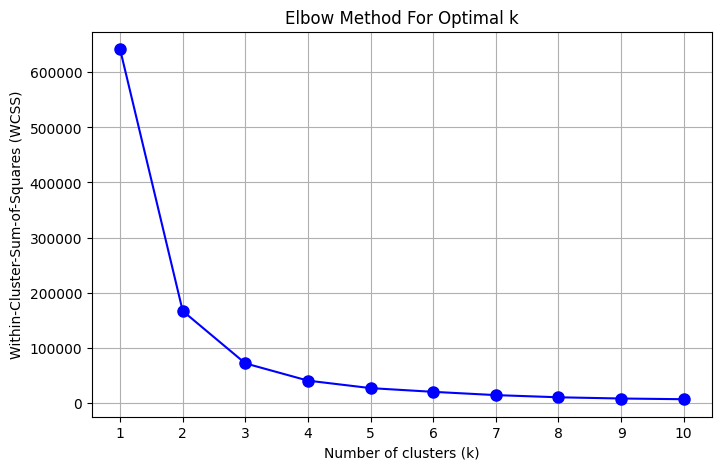

In [0]:
plt.figure(figsize=(8,5))
plt.plot(k_values, wcss, 'bo-', markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-Cluster-Sum-of-Squares (WCSS)')
plt.title('Elbow Method For Optimal k')
plt.xticks(k_values)
plt.grid(True)
plt.show()


In [0]:
import io, contextlib


with contextlib.redirect_stderr(io.StringIO()):
    import sklearn   # or the function call that triggers the warning


from sklearn.cluster import KMeans

# Run Kmeans Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
missed_pdf['cluster'] = kmeans.fit_predict(X)


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffd1279cb2e0>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'


In [0]:
centers = sorted(kmeans.cluster_centers_.flatten())
print("Cluster centers (pct_of_bitehigh):", centers)


Cluster centers (pct_of_bitehigh): [4.675495385167018, 19.294997294489406, 37.12972068526463]


In [0]:
import numpy as np

# Convert centers to a NumPy array before sorting
sorted_clusters = np.array(centers).argsort()

# Map cluster number to descriptive names
cluster_names = {
    sorted_clusters[0]: 'low',
    sorted_clusters[1]: 'med',
    sorted_clusters[2]: 'high'
}

# Create a new column with descriptive cluster names
missed_pdf['cluster_name'] = missed_pdf['cluster'].map(cluster_names)

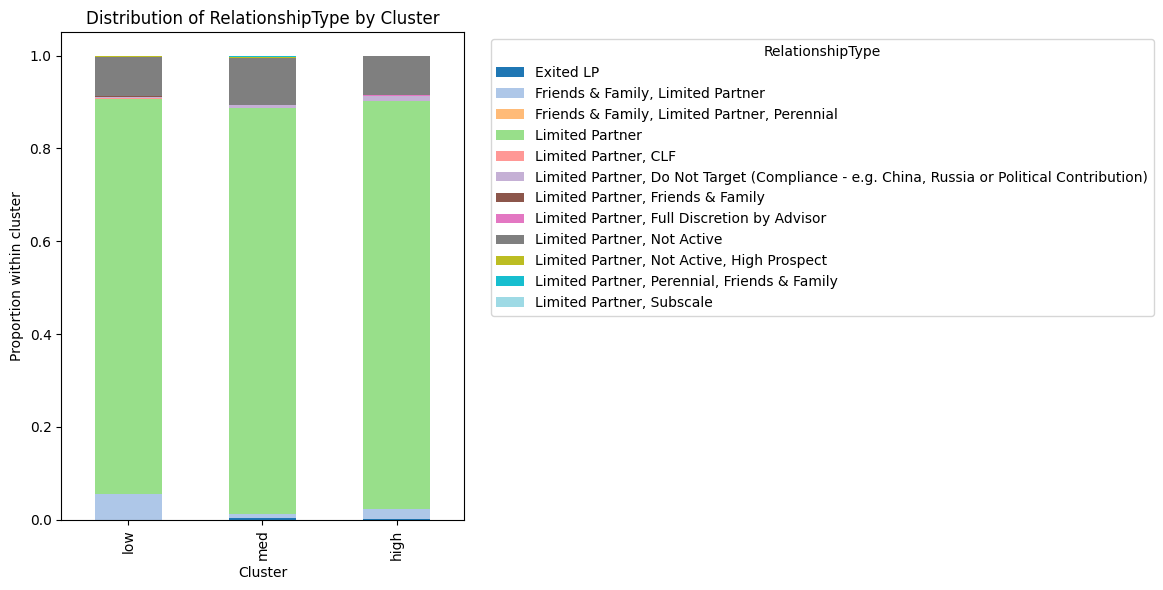

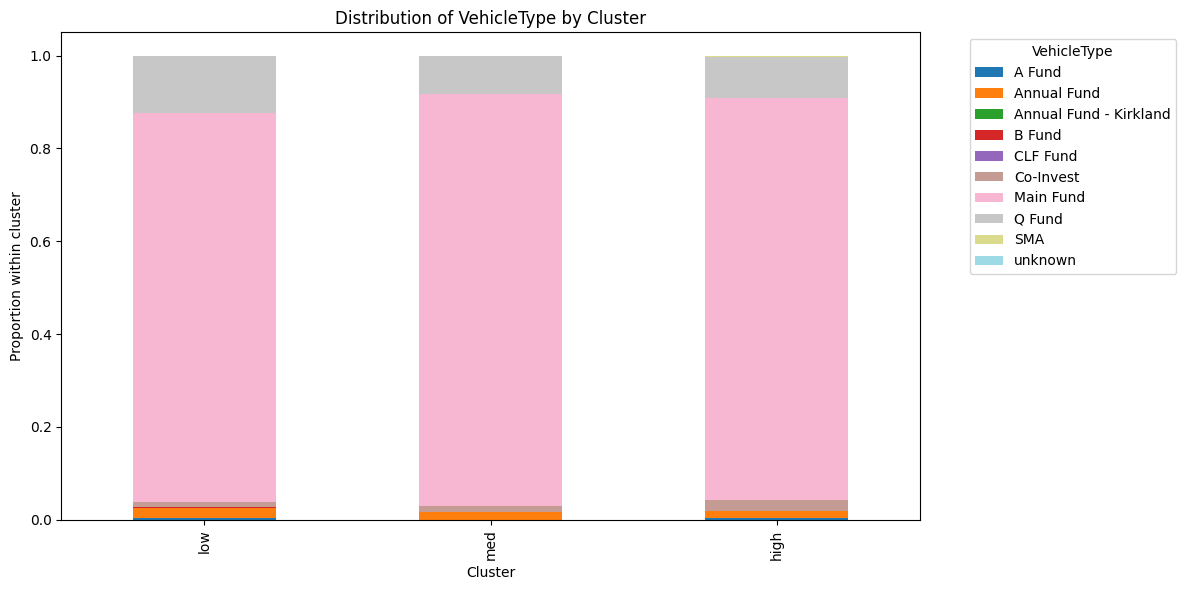

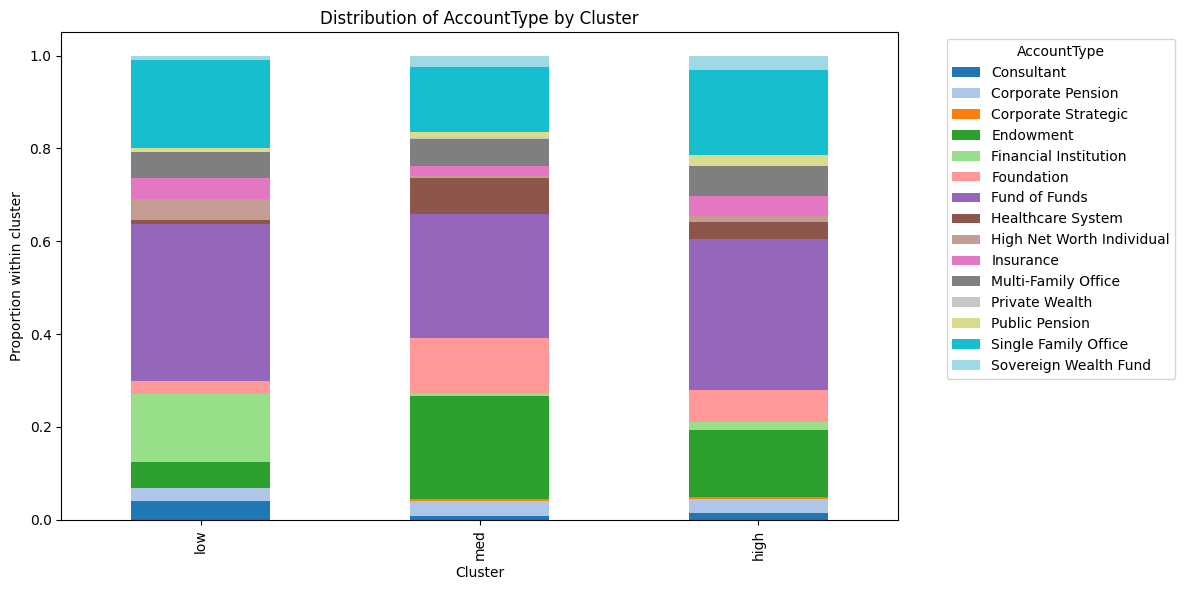

In [0]:
import pandas as pd
cluster_order = ['low', 'med', 'high']

# Set ordered categorical dtype
missed_pdf['cluster_name'] = pd.Categorical(missed_pdf['cluster_name'], categories=cluster_order, ordered=True)

def plot_categorical_distribution(df, category_col, cluster_col='cluster_name'):
    crosstab = pd.crosstab(df[cluster_col], df[category_col], normalize='index')
    crosstab.plot(kind='bar', stacked=True, figsize=(12,6), colormap='tab20')
    plt.title(f'Distribution of {category_col} by Cluster')
    plt.ylabel('Proportion within cluster')
    plt.xlabel('Cluster')
    plt.legend(title=category_col, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Plot with ordered clusters
plot_categorical_distribution(missed_pdf, 'RelationshipType')
plot_categorical_distribution(missed_pdf, 'VehicleType')
plot_categorical_distribution(missed_pdf, 'AccountType')


Financial Institutions consistently have very low Commitment Ratios, so it's worth re-examining their fundraising strategy. Maybe there are consistent missied opportunities for higher fundraising, or the metrics for evaluating their 'BiteHigh' should be re-examined. However, Healthcare/Foundation/Endowment have very high ratios, which indicates that their fundraising strategy is more effective.
